# EDA: Timeseries Analysis 

Use of basic and advanced techniques for timeseries analysis and prediction of crypto-currencies prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('../data/bitcoin_price.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Oct 03, 2017",4408.46,4432.47,4258.89,4317.48,"1,288,020,000","73,181,300,000"
1,"Oct 02, 2017",4395.81,4470.23,4377.46,4409.32,"1,431,730,000","72,963,200,000"
2,"Oct 01, 2017",4341.05,4403.74,4269.81,4403.74,"1,208,210,000","72,047,300,000"
3,"Sep 30, 2017",4166.11,4358.43,4160.86,4338.71,"1,207,450,000","69,136,600,000"
4,"Sep 29, 2017",4171.62,4214.63,4039.29,4163.07,"1,367,050,000","69,219,200,000"


In [3]:
data['Date']=pd.to_datetime(data['Date'], format='%b %d, %Y')
close_price = data[['Date','Close']]
close_price.index = close_price['Date']
close_price_ts=close_price['Close']

# chronological order
close_price_ts=close_price_ts.sort_index()
close_price_ts.head()

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
2013-05-01    116.99
2013-05-02    105.21
Name: Close, dtype: float64

## Do we have missing values?

In [5]:
nan_values=pd.isnull(close_price_ts)
nan_values[nan_values==True]

Series([], Name: Close, dtype: bool)

There are no values missing. Great news !

## Temporal structure

### Raw signal

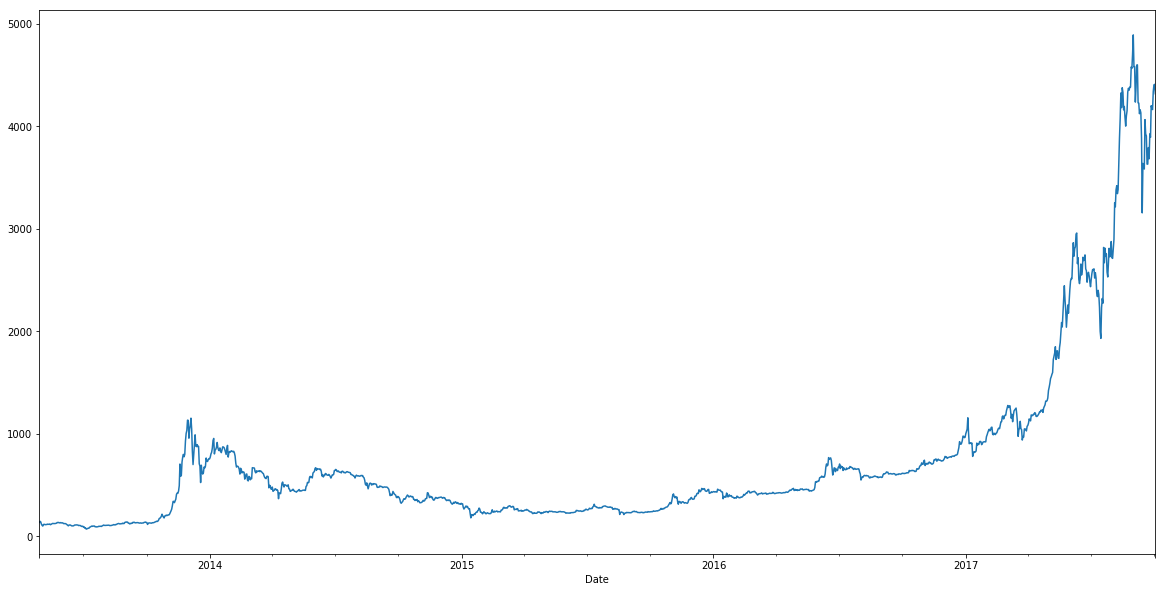

In [106]:
plt.figure(figsize=(20,10))
close_price_ts.plot()
plt.show()

### Lag plot

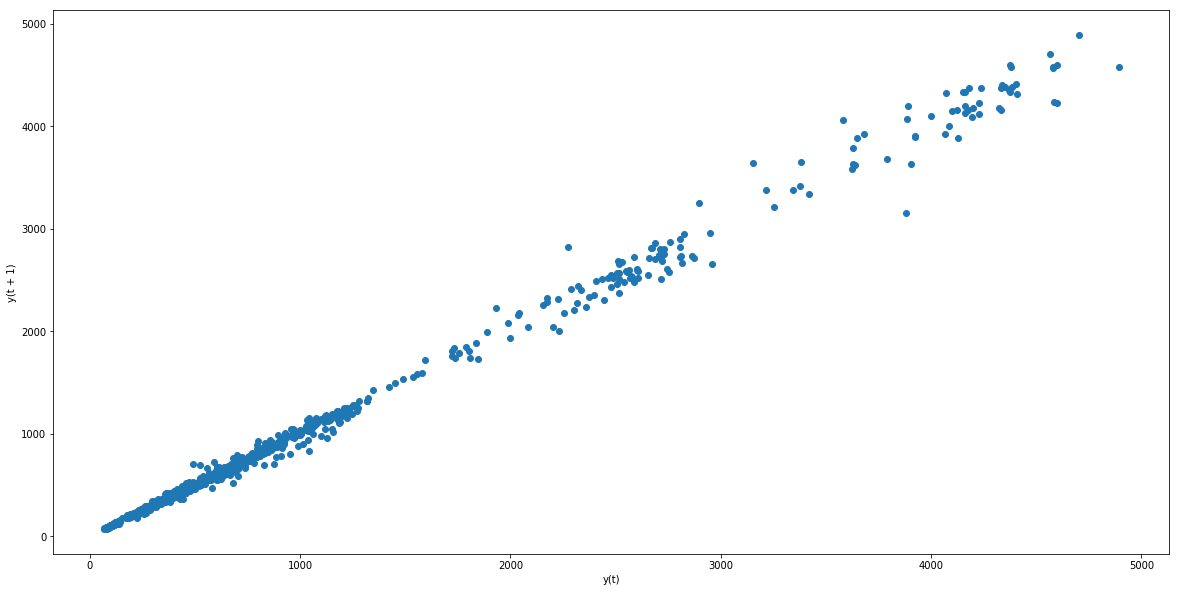

In [107]:
from pandas.plotting import lag_plot

plt.figure(figsize=(20,10))
lag_plot(close_price_ts)
plt.show()

This lag plot shows a linear pattern. So the signal does not seem random at all. Therefore ARIMA might work well.

### Autocorrelation plot

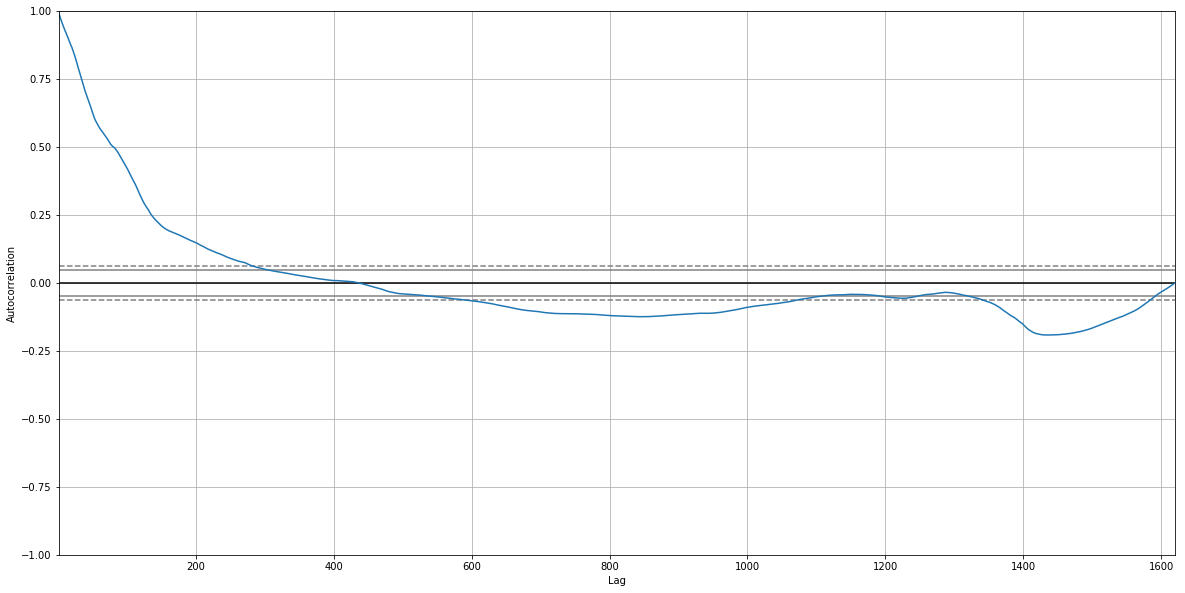

In [29]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,10))
autocorrelation_plot(close_price_ts)
plt.show()



## Distribution

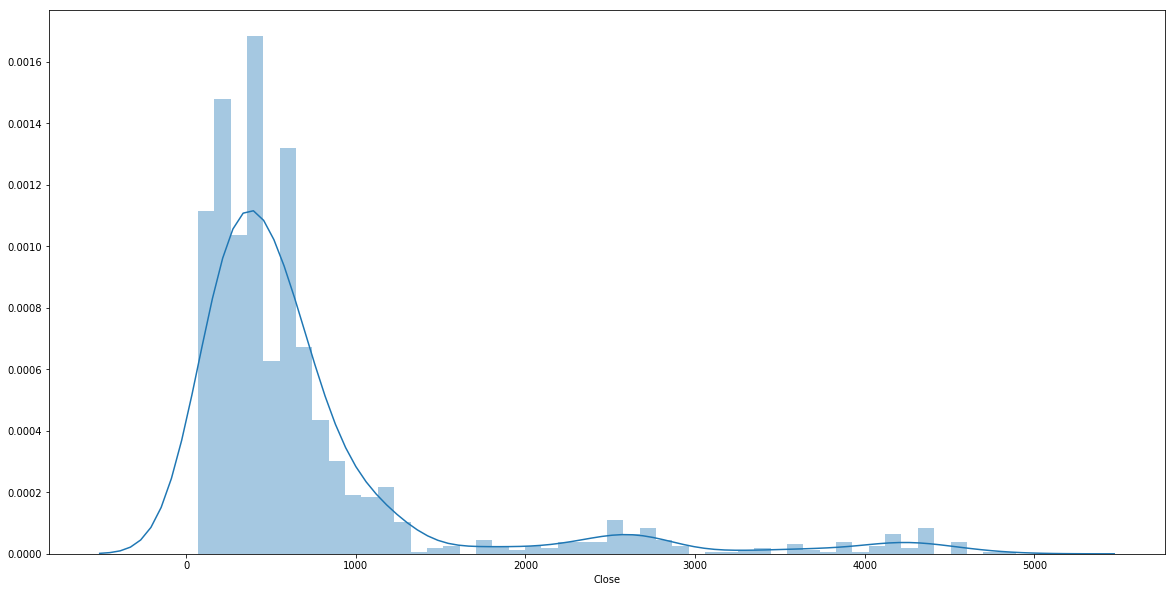

In [108]:
plt.figure(figsize=(20,10))
sns.distplot(close_price_ts)
plt.show()

## Changes over time

### Boxplot

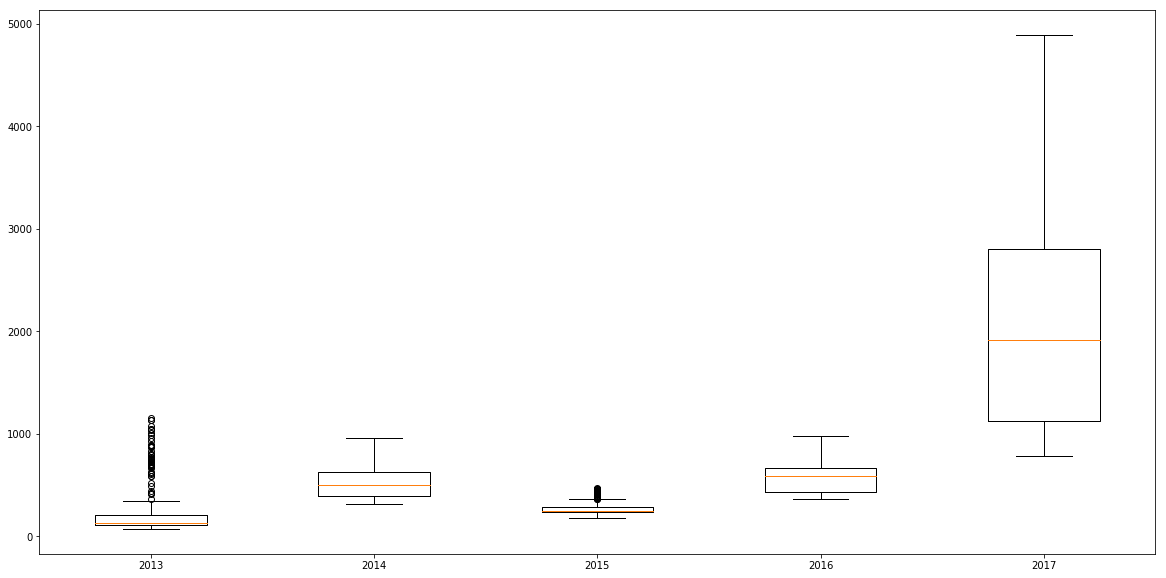

In [130]:
from pandas import TimeGrouper
groups = close_price_ts.groupby(TimeGrouper('A'))

data=[]
years=[]
x_i=1
x=[]
for name, group in groups:
    x.append(x_i)
    data = data+[group.values]
    years.append(name.year)
    x_i+=1
    
# multiple box plots on one figure
plt.figure(figsize=(20,10))
plt.boxplot(data)
plt.xticks(x, years)
plt.show()

Major increase in 2017 with more variability. Therefore, volatitility has increased in 2017.

## Transformations of the signal

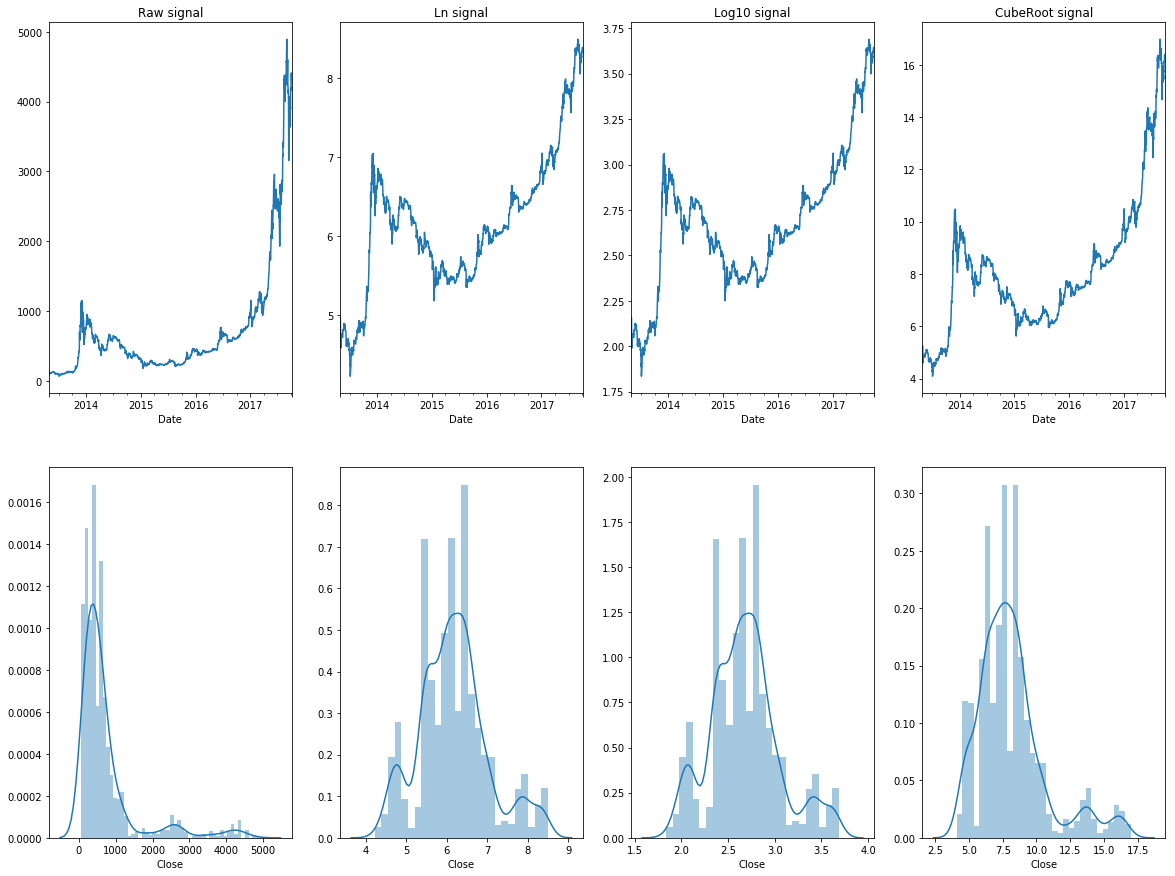

In [6]:
close_price_ts_ln = close_price_ts.apply(lambda x: np.log(x))
close_price_ts_log = close_price_ts.apply(lambda x: np.log10(x))
close_price_ts_cuberoot = close_price_ts.apply(lambda x: x**(1./3.))

plt.figure(figsize=(20,15))

plt.subplot(2,4,1)
close_price_ts.plot()
plt.title('Raw signal')

plt.subplot(2,4,2)
close_price_ts_ln.plot()
plt.title('Ln signal')

plt.subplot(2,4,3)
close_price_ts_log.plot()
plt.title('Log10 signal')

plt.subplot(2,4,4)
close_price_ts_cuberoot.plot()
plt.title('CubeRoot signal')

plt.subplot(2,4,5)
sns.distplot(close_price_ts)

plt.subplot(2,4,6)
sns.distplot(close_price_ts_ln)

plt.subplot(2,4,7)
sns.distplot(close_price_ts_log)

plt.subplot(2,4,8)
sns.distplot(close_price_ts_cuberoot)


plt.show()

## Time lag

The idea here is to see if there is a relationship between time lags

In [7]:
print(close_price_ts.shift(0).head())
print()
print(close_price_ts.shift(1).head())
print()
print(close_price_ts.shift(2).head())
print()

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
2013-05-01    116.99
2013-05-02    105.21
Name: Close, dtype: float64
()
Date
2013-04-28       NaN
2013-04-29    134.21
2013-04-30    144.54
2013-05-01    139.00
2013-05-02    116.99
Name: Close, dtype: float64
()
Date
2013-04-28       NaN
2013-04-29       NaN
2013-04-30    134.21
2013-05-01    144.54
2013-05-02    139.00
Name: Close, dtype: float64
()


In [188]:
lagmax=30
all_lags = list(range(1,lagmax+1))

lagged_data = pd.concat([close_price_ts]+[close_price_ts.shift(i) for i in all_lags],axis=1,
                       keys=['original']+['Lag%d' % j for j in all_lags]).dropna()
lagged_data.head()

,original,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,Lag21,Lag22,Lag23,Lag24,Lag25,Lag26,Lag27,Lag28,Lag29,Lag30
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-28,129.0,129.75,133.48,131.98,133.20,126.70,123.89,122.88,122.00,121.99,...,111.50,112.30,115.91,112.50,97.75,105.21,116.99,139.00,144.54,134.21
2013-05-29,132.3,129.00,129.75,133.48,131.98,133.20,126.70,123.89,122.88,122.00,...,113.57,111.50,112.30,115.91,112.50,97.75,105.21,116.99,139.00,144.54
2013-05-30,128.8,132.30,129.00,129.75,133.48,131.98,133.20,126.70,123.89,122.88,...,112.67,113.57,111.50,112.30,115.91,112.50,97.75,105.21,116.99,139.00
2013-05-31,129.0,128.80,132.30,129.00,129.75,133.48,131.98,133.20,126.70,123.89,...,117.20,112.67,113.57,111.50,112.30,115.91,112.50,97.75,105.21,116.99
2013-06-01,129.3,129.00,128.80,132.30,129.00,129.75,133.48,131.98,133.20,126.70,...,115.24,117.20,112.67,113.57,111.50,112.30,115.91,112.50,97.75,105.21


### Model the lags

In [189]:
import statsmodels.formula.api as smf
formula = 'original ~ trend'
for i in all_lags:
    formula = formula + ' + Lag%i'%i
model_lagged=smf.ols(formula, data=lagged_data.assign(trend=np.arange(len(lagged_data))))

res_lagged = model_lagged.fit()
print(res_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:               original   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.447e+04
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        15:54:11   Log-Likelihood:                -8476.2
No. Observations:                1590   AIC:                         1.702e+04
Df Residuals:                    1558   BIC:                         1.719e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3320      2.561     -1.301      0.1

[  9.47884597e-01   4.89316719e-02   2.55860282e-02  -5.21752965e-02
   8.13146453e-02  -1.61983959e-02  -5.35620746e-02  -1.78615518e-02
   5.47165427e-02   1.00928402e-02   8.36980945e-03   9.03769863e-02
  -2.26029223e-01   1.00925423e-01   1.96702896e-03  -4.61678045e-04
   6.76173961e-02   1.26029796e-02  -5.61767498e-02  -2.15373033e-02
  -1.85551787e-01   1.96528576e-01  -1.47281977e-01   1.81485805e-01
   6.58915219e-02  -1.58863525e-01   1.63223833e-01  -3.21677862e-01
   3.43532022e-02   1.72171313e-01]
-1.30841262997


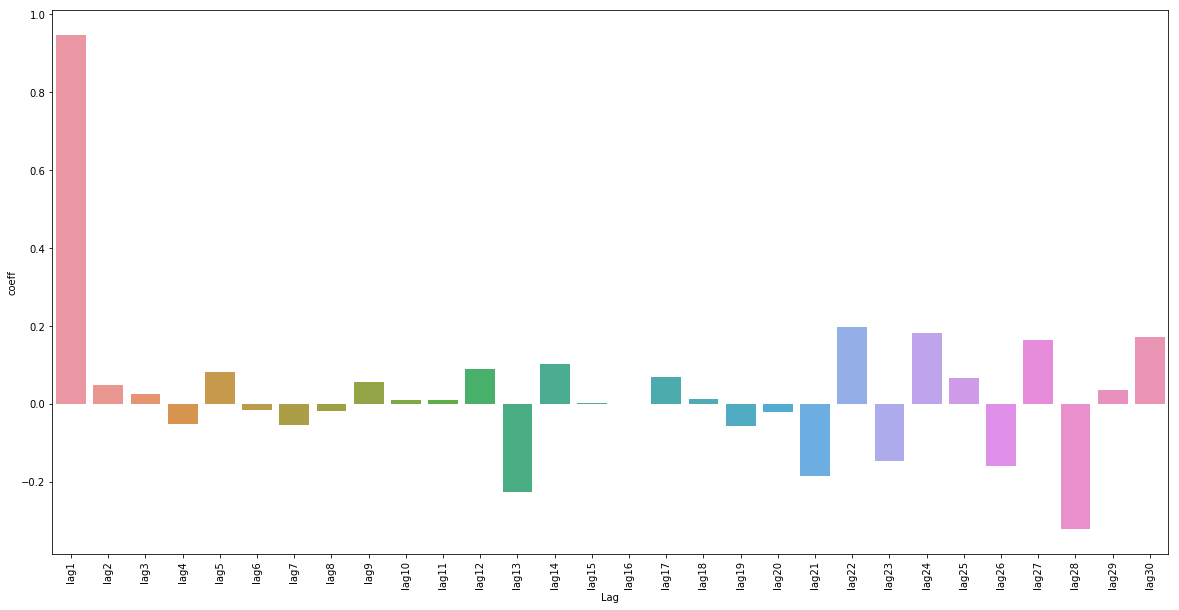

In [190]:
from sklearn.linear_model import LinearRegression
y = lagged_data['original'].values
X = lagged_data.drop('original',1).values

ols = LinearRegression()
ols.fit(X,y)
print(ols.coef_)
print(ols.intercept_)
ols_coefs_per_lag=pd.DataFrame({'Lag':['lag%d' %i for i in all_lags],'coeff':ols.coef_})

plt.figure(figsize=(20,10))
lag_coeff_barplot=sns.barplot(x='Lag',y='coeff',data=ols_coefs_per_lag)
for item in lag_coeff_barplot.get_xticklabels():
    item.set_rotation(90)
plt.show()

### Correlation between the lags

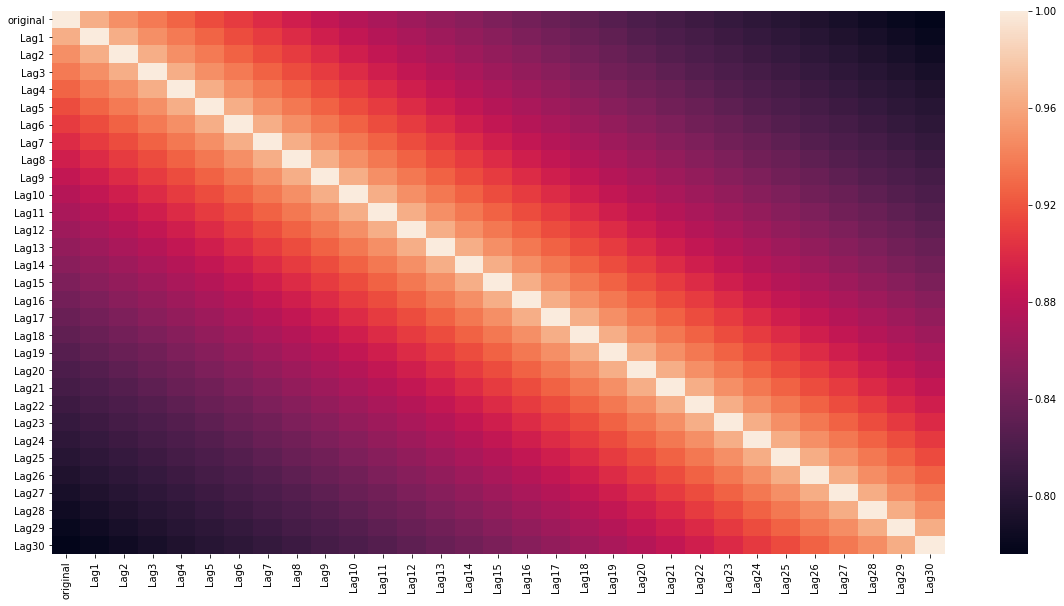

In [191]:
plt.figure(figsize=(20,10))
sns.heatmap(lagged_data.corr(method='kendall'))
plt.show()

## Signal decomposition

In [193]:
y = close_price_ts.copy()

# first differencing 
y_diff=y.diff().dropna()







### Compute trend

#### By differencing
source: https://machinelearningmastery.com/time-series-trends-in-python/

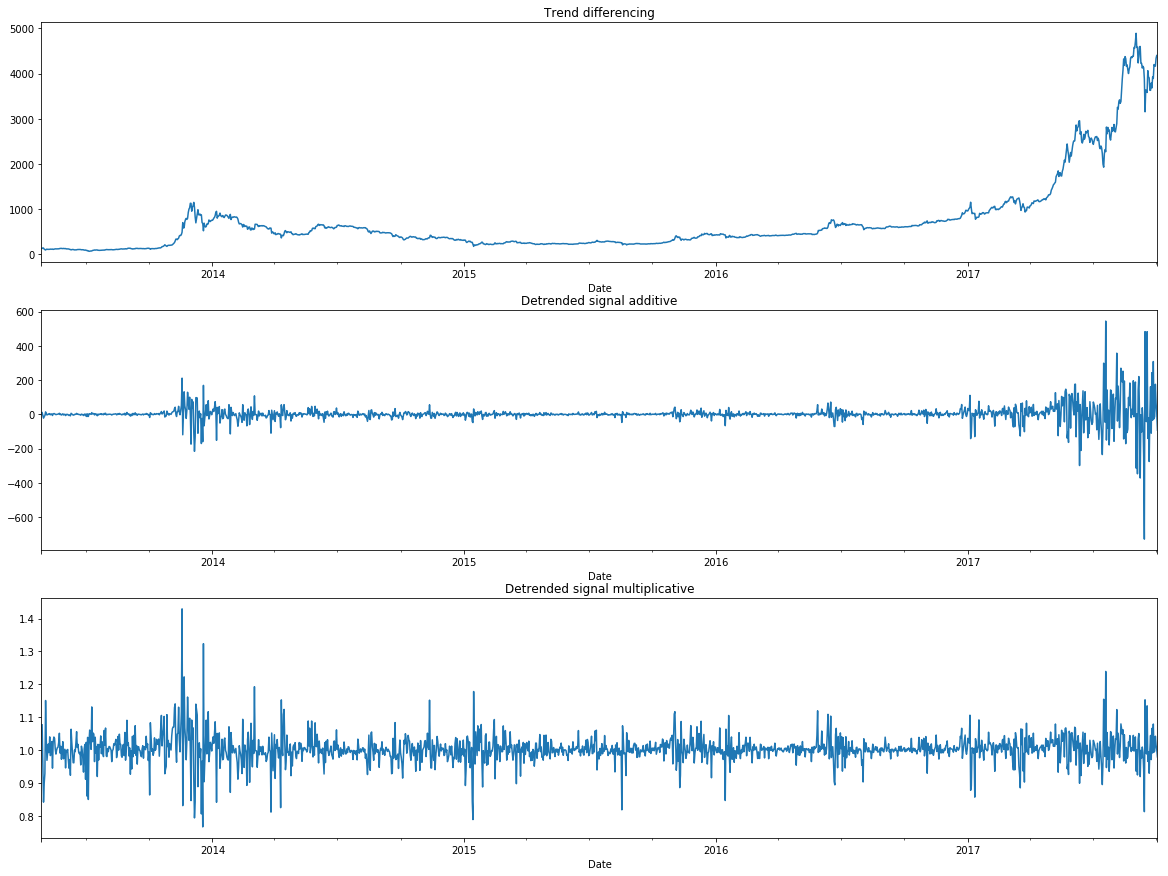

In [62]:
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
trend_diff = y - y_diff
trend_diff.plot()
plt.title('Trend differencing')

plt.subplot(3,1,2)
detrended_diff_add = y - trend_diff
detrended_diff_add.plot()
plt.title('Detrended signal additive')

plt.subplot(3,1,3)
detrended_diff_multi = y/trend_diff
detrended_diff_multi.plot()
plt.title('Detrended signal multiplicative')
plt.show()

#### With median/mean average

/Users/auguste/Documents/fibronostics_code/Envs/machine_learning/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=8,center=False).median()
  after removing the cwd from sys.path.


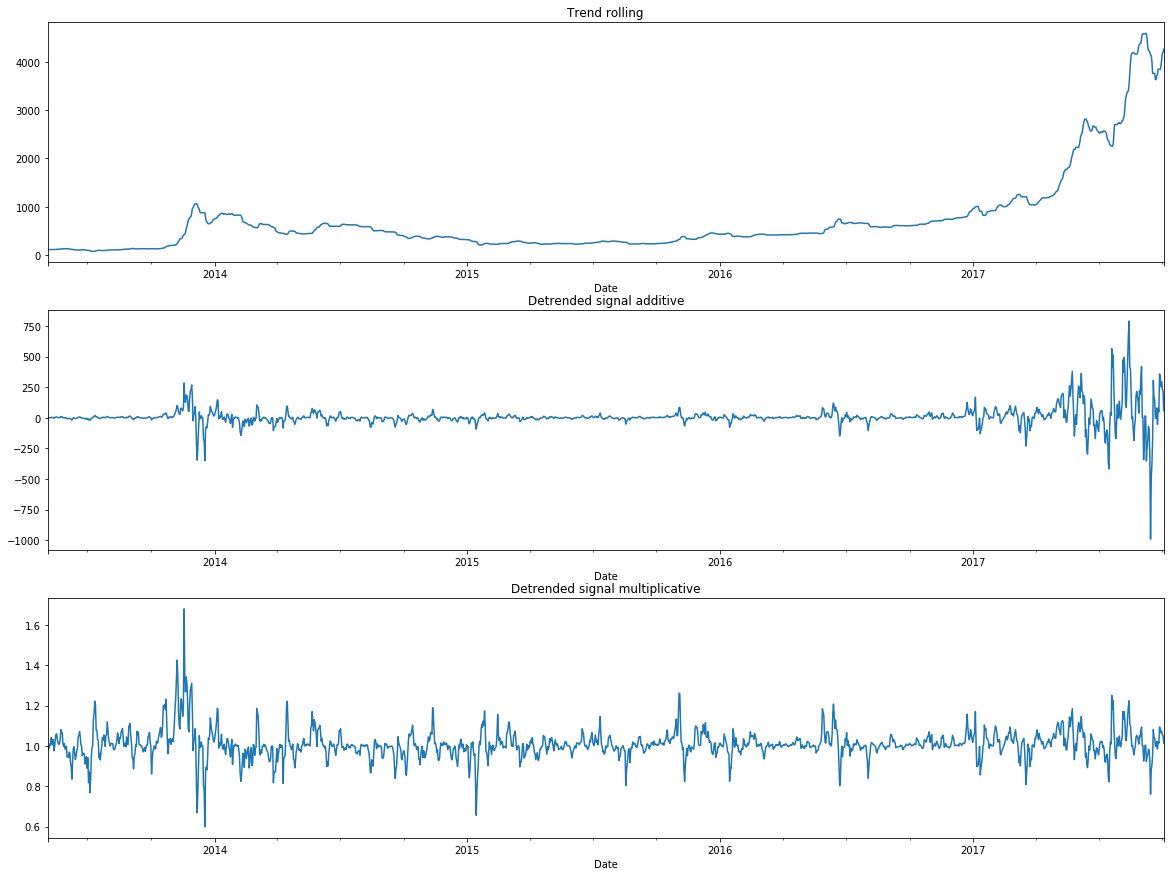

In [63]:
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
trend_rolling = pd.rolling_median(y,8)
trend_rolling.dropna().plot()
plt.title('Trend rolling')

plt.subplot(3,1,2)
detrended_rolling_add = y-trend_rolling
detrended_rolling_add.dropna().plot()
plt.title('Detrended signal additive')

plt.subplot(3,1,3)
detrended_rolling_mult = y/trend_rolling
detrended_rolling_mult.dropna().plot()
plt.title('Detrended signal multiplicative')
plt.show()

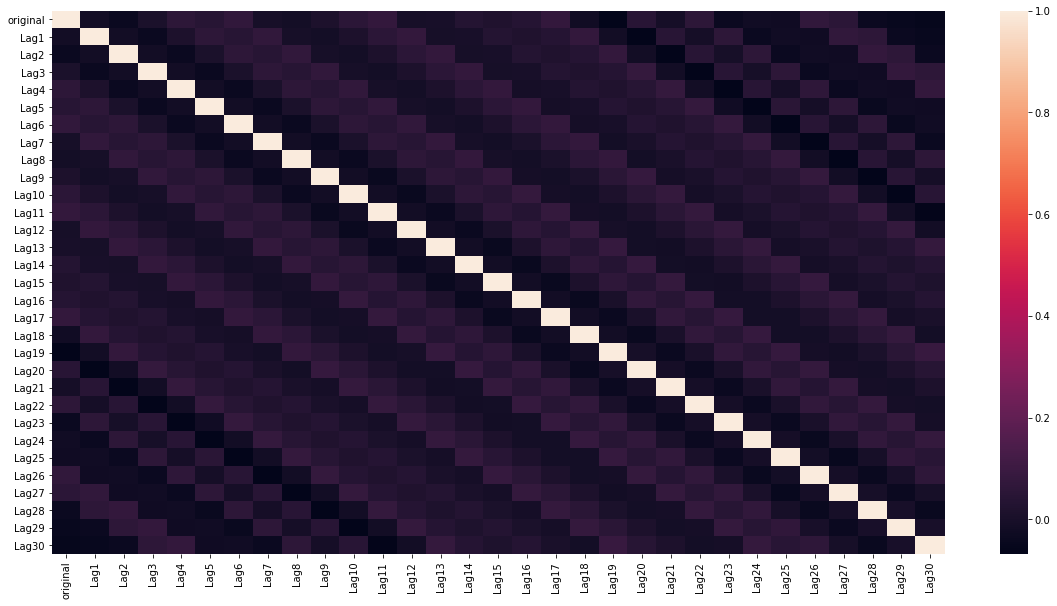

In [102]:
plt.figure(figsize=(20,10))
lagged_detrended = pd.concat([detrended_diff_multi]+[detrended_diff_multi.shift(i) for i in all_lags],axis=1,
                       keys=['original']+['Lag%d' % j for j in all_lags]).dropna()

sns.heatmap(lagged_detrended.corr(method='pearson'))
plt.show()

The detrended signal seems to have some degree of periodicity/seasonality


   ### Additive Decomposition 

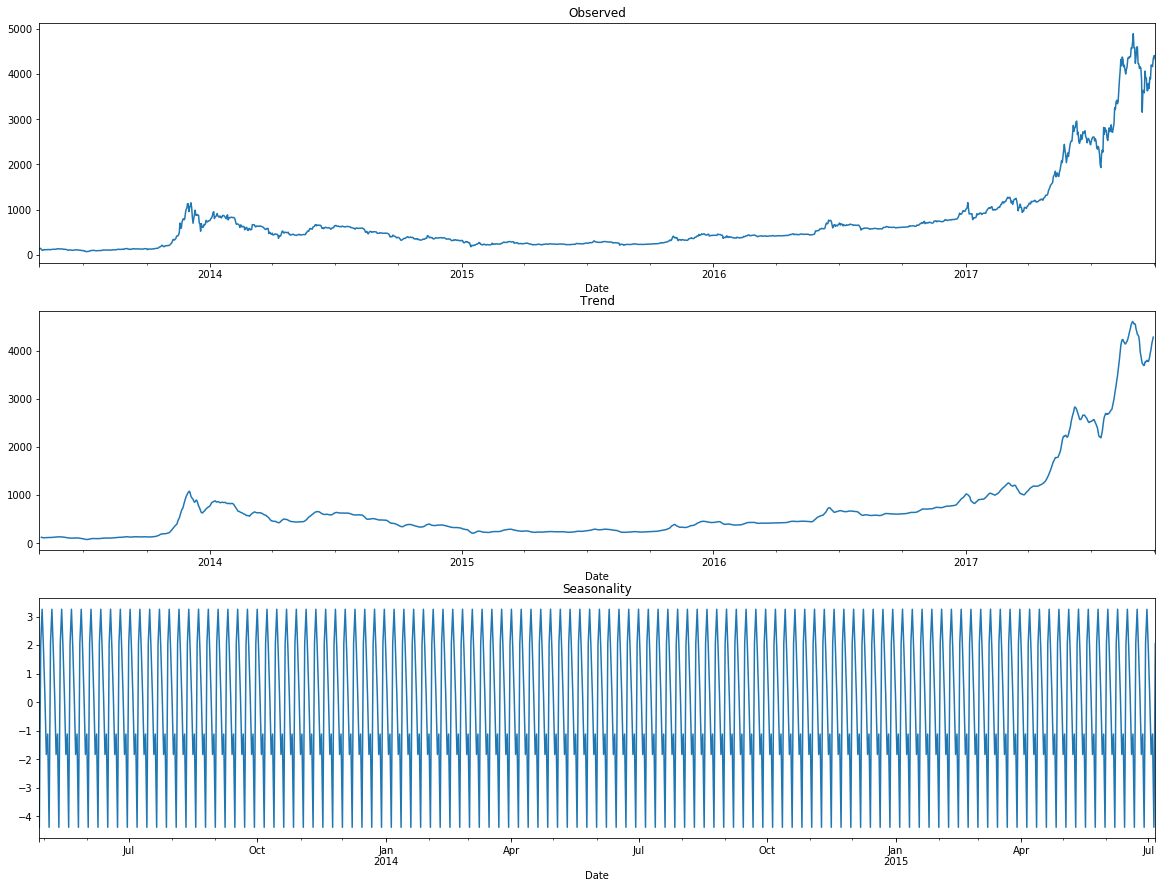

In [96]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(y, model='additive')

plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
decomposition.observed.plot()
plt.title('Observed')

plt.subplot(3,1,2)
decomposition.trend.plot()
plt.title('Trend')

plt.subplot(3,1,3)
decomposition.seasonal.head(800).plot()
plt.title('Seasonality')


plt.show()

### Multiplicative Decomposition

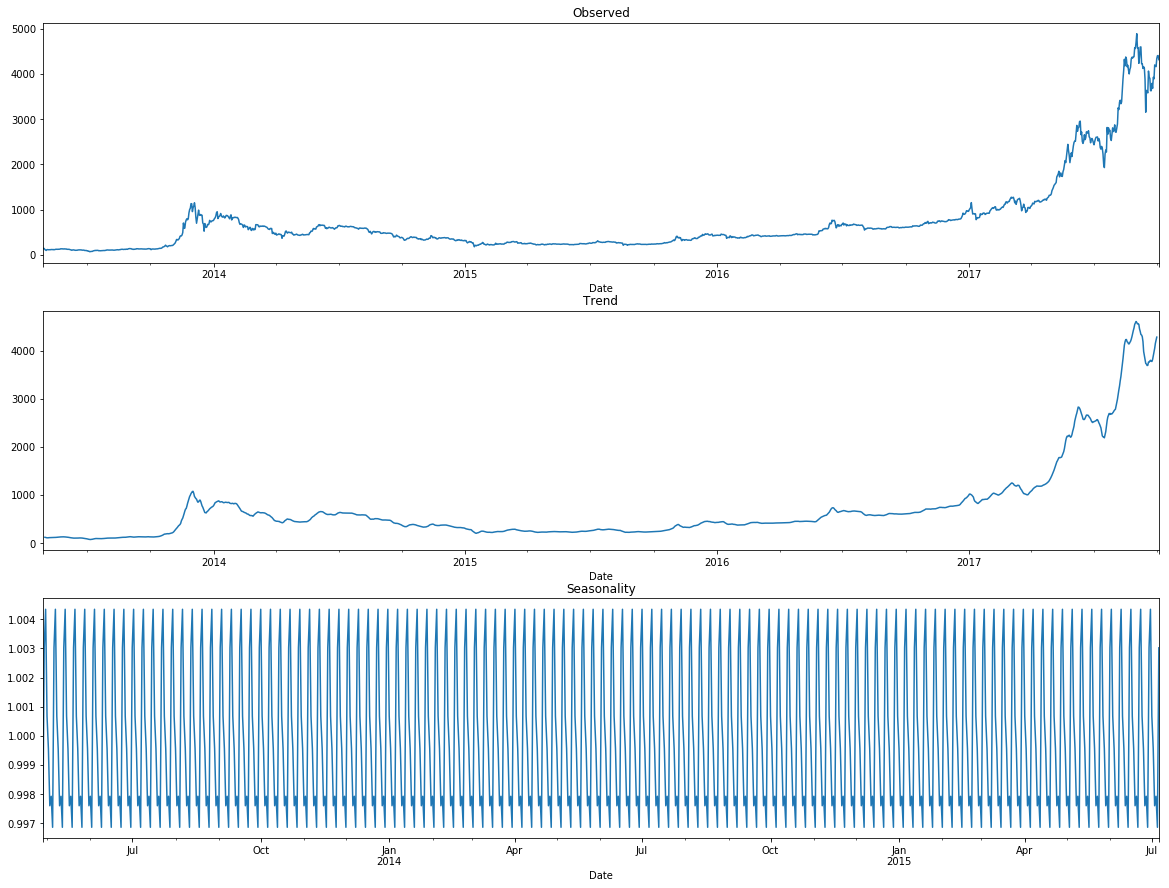

In [95]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')

plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
decomposition.observed.plot()
plt.title('Observed')

plt.subplot(3,1,2)
decomposition.trend.plot()
plt.title('Trend')

plt.subplot(3,1,3)
decomposition.seasonal.head(800).plot()
plt.title('Seasonality')


plt.show()


It appears here that we could pick either an additive or a multiplicative decomposition

## Stationarity

## Baseline forecasting model: Persistence Algorithm or 'Naive Forecast'

### Predict with the previous data point

In [139]:
baseline_data = pd.concat([close_price_ts.shift(1), close_price_ts], axis=1).dropna()
baseline_data.columns = ['t-1', 't']
baseline_data.head()

,t-1,t
Date,,
2013-04-29,134.21,144.54
2013-04-30,144.54,139.00
2013-05-01,139.00,116.99
2013-05-02,116.99,105.21
2013-05-03,105.21,97.75


### Define train and test datasets

In [144]:
X=baseline_data['t-1'].values
y=baseline_data['t'].values
n=len(X)
n_train=int(0.66*n)
n_test=n-n_train

X_train=X[:n_train]
X_test=X[n_train:]

y_train=y[:n_train]
y_test=y[n_train:]

### Persistence algo

In [145]:
# persistence model
def model_persistence(x):
    return x

### Evaluation of baseline model

In [155]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pred_baseline=[]
for x in X_test:
    pred = model_persistence(x)
    pred_baseline.append(pred)

baseline_mse = mean_squared_error(y_test,pred_baseline)
baseline_mae = mean_absolute_error(y_test,pred_baseline)
baseline_r2 = r2_score(y_test,pred_baseline)

print('baseline MSE:')
print(baseline_mse)
print('')
print('baseline MAE:')
print(baseline_mae)
print('')
print('baseline R2')
print(baseline_r2)


baseline MSE:
7345.18611887

baseline MAE:
41.5088021779

baseline R2
0.994441488566


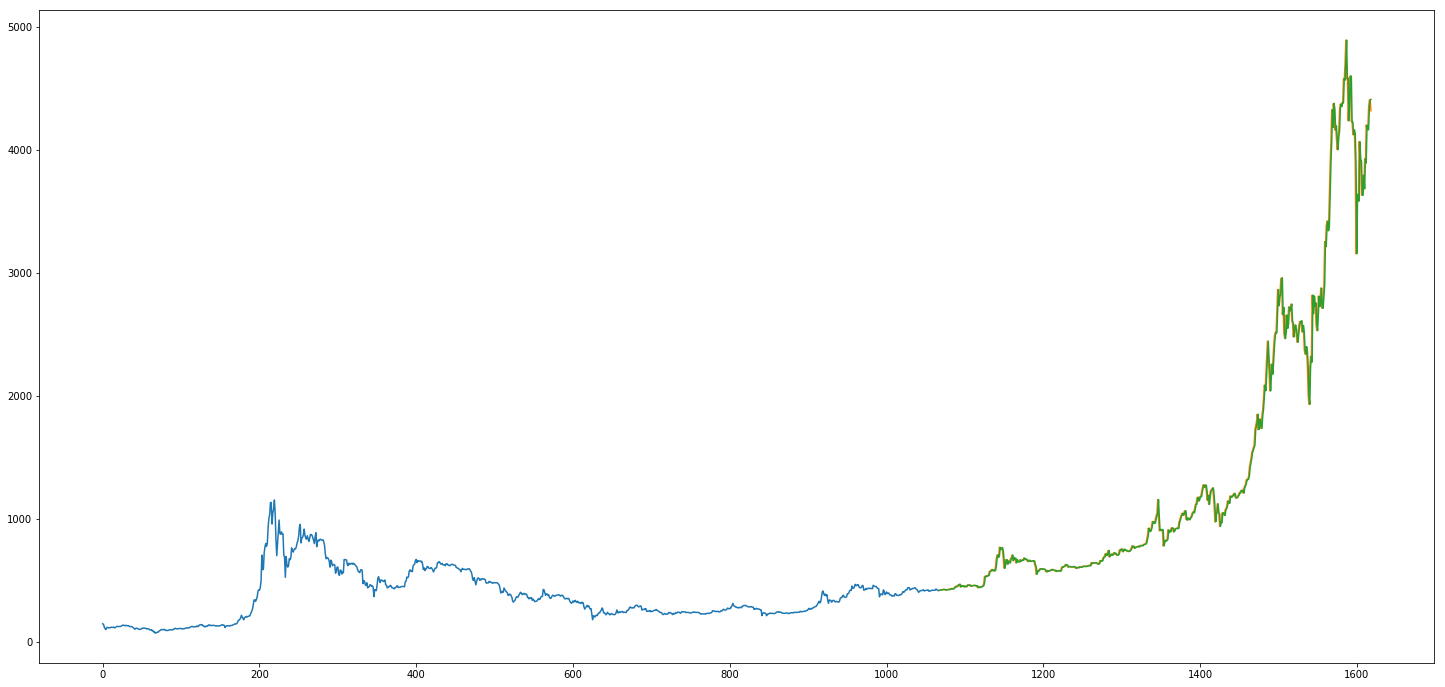

In [159]:
plt.figure(figsize=(25,12))
plt.plot(y_train)
plt.plot([None for i in y_train] + [x for x in y_test])
plt.plot([None for i in y_train] + [x for x in pred_baseline])
plt.show()

## AR model

Autoregressive: uses previous values as features to predict future values ('regression from itself')

### Autocorrelation

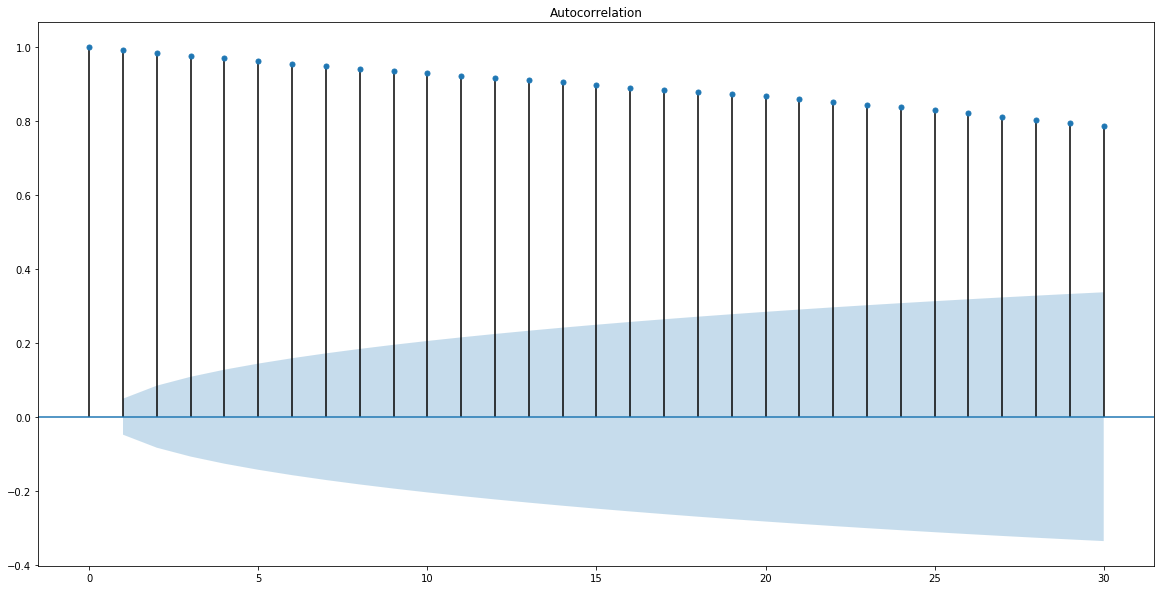

In [175]:
from statsmodels.graphics.tsaplots import plot_acf
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plot_acf(close_price_ts, lags=lagmax,ax=ax)
plt.show()

Lag: 23
Coefficients: [  1.47626846e+00   9.96417477e-01  -6.30995745e-02  -2.76901530e-02
   1.59685852e-01  -3.62316443e-03   3.50619787e-02  -1.00218259e-01
  -7.44609072e-03  -7.43467998e-03   3.38891777e-02   5.52381445e-02
  -6.01869885e-02   1.69531939e-02   8.02374928e-04  -5.80525824e-02
   2.49341059e-02   4.19591170e-02  -1.41855379e-01  -3.64978210e-02
   1.71321567e-01  -9.63396770e-02   9.64081942e-02  -3.16327218e-02]

Train MSE: 559.423
Train MAE: 12.427
Train R2: 0.992

Test MSE: 3957455.993
Test MAE: 1736.319
Test R2: -3.294


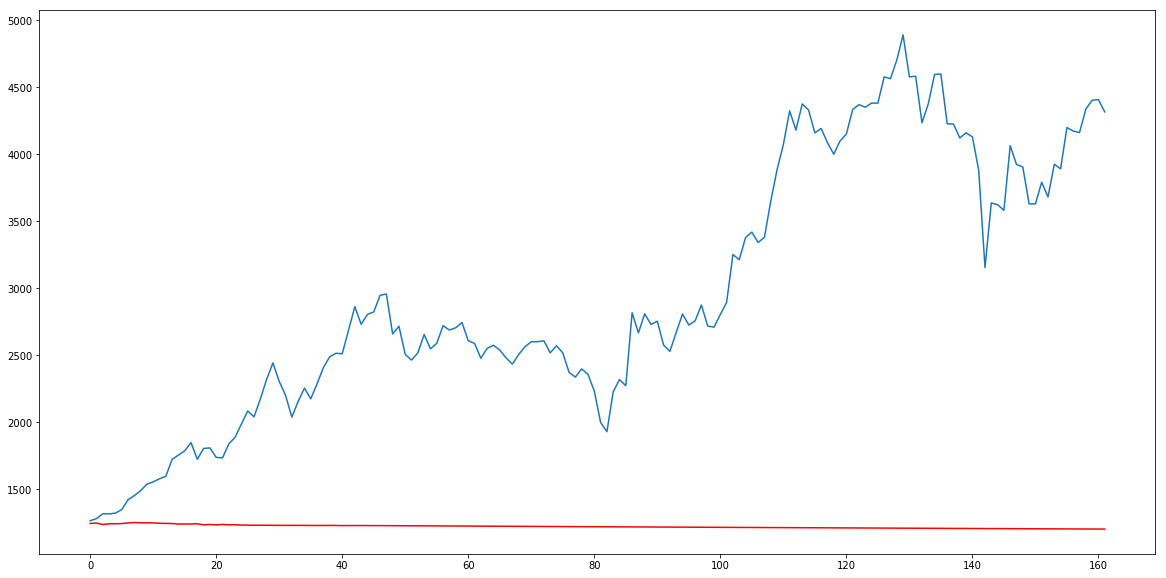

In [225]:
from statsmodels.tsa.ar_model import AR
X=close_price_ts.values
n=len(X)
n_train=int(0.90*n)
n_test=n-n_train
X_train,X_test=X[:n_train],X[n_train:]

# train autoregression
ar_model=AR(X_train)
ar_model_fit=ar_model.fit()
lag=ar_model_fit.k_ar
print('Lag: %s' % lag)
print('Coefficients: %s' % ar_model_fit.params)
print('')
# make predictions

pred_ar_train = ar_model_fit.predict(start=lag, end=len(X_train)-1, dynamic=False)
pred_ar_test = ar_model_fit.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, dynamic=False)

ar_mse_train = mean_squared_error(X_train[lag:],pred_ar_train)
ar_mae_train = mean_absolute_error(X_train[lag:],pred_ar_train)
ar_r2_train = r2_score(X_train[lag:],pred_ar_train)

ar_mse_test = mean_squared_error(X_test,pred_ar_test)
ar_mae_test = mean_absolute_error(X_test,pred_ar_test)
ar_r2_test = r2_score(X_test,pred_ar_test)

print('Train MSE: %.3f' % ar_mse_train)
print('Train MAE: %.3f' % ar_mae_train)
print('Train R2: %.3f' % ar_r2_train)
print('')
print('Test MSE: %.3f' % ar_mse_test)
print('Test MAE: %.3f' % ar_mae_test)
print('Test R2: %.3f' % ar_r2_test)

# plot results
plt.figure(figsize=(20,10))
#plt.plot(X_train)
#plt.plot([None for i in X_train] + [x for x in X_test])
#plt.plot([None for i in X_train] + [x for x in pred_ar_test], color='red')
plt.plot(X_test)
plt.plot(pred_ar_test,color='red')
plt.show()